In [51]:
import pandas as pd

df = df.rename(columns={
    # Identité / localisation
    "BuildingType": "building_type",
    "ZipCode": "zip_code",
    "CouncilDistrictCode": "council_district_code",
    "Latitude": "latitude",
    "Longitude": "longitude",

    # Surfaces / usages
    "PropertyGFAParking": "property_gfa_parking",
    "LargestPropertyUseType": "largest_property_use_type",
    "SecondLargestPropertyUseType": "second_largest_property_use_type",
    "SecondLargestPropertyUseTypeGFA": "second_largest_property_use_type_gfa",
    "ThirdLargestPropertyUseType": "third_largest_property_use_type",
    "ThirdLargestPropertyUseTypeGFA": "third_largest_property_use_type_gfa",
    
    # Features dérivées
    "buildingage": "building_age",
    "UsageCount": "usage_count",
    "ParkingRatio": "parking_ratio",
    "FloorDensity": "floor_density",
    "DistanceToDowntown_km": "distance_to_downtown_km",
})

df.head()


,building_type,primary_property_type,zip_code,council_district_code,neighborhood,latitude,longitude,number_of_buildings,number_of_floors,property_gfa_total,...,second_largest_property_use_type,second_largest_property_use_type_gfa,third_largest_property_use_type,third_largest_property_use_type_gfa,SiteEUIWN(kBtu/sf),building_age,usage_count,parking_ratio,floor_density,distance_to_downtown_km
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,...,Unknown,31733.045429,Unknown,12311.108329,84.300003,98,1,0.000000,0.000136,0.800050
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,...,Parking,15064.000000,Restaurant,4622.000000,97.900002,29,3,0.145453,0.000106,0.787077
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,...,Unknown,31733.045429,Unknown,12311.108329,97.699997,56,1,0.205748,0.000043,0.970109
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,...,Unknown,31733.045429,Unknown,12311.108329,113.300003,99,1,0.000000,0.000163,0.944139
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,...,Parking,68009.000000,Swimming Pool,0.000000,118.699997,45,3,0.353115,0.000103,1.048092


## 4.1 – Définition de la variable cible et des features

In [52]:
TARGET = "SiteEUIWN(kBtu/sf)"

features = [c for c in df_model.columns if c != TARGET]

X = df_model[features]
y = df_model[TARGET]

print("X :", X.shape)
print("y :", y.shape)
print("Colonnes X :", list(X.columns))


X : (1510, 22)
y : (1510,)
Colonnes X : ['building_type', 'primary_property_type', 'zip_code', 'council_district_code', 'neighborhood', 'latitude', 'longitude', 'number_of_buildings', 'number_of_floors', 'property_gfa_total', 'property_gfa_parking', 'ListOfAllPropertyUseTypes', 'largest_property_use_type', 'second_largest_property_use_type', 'second_largest_property_use_type_gfa', 'third_largest_property_use_type', 'third_largest_property_use_type_gfa', 'building_age', 'usage_count', 'parking_ratio', 'floor_density', 'distance_to_downtown_km']


## 4.2 – Train/Test Split (80% / 20%)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)


X_train : (1208, 22)
X_test  : (302, 22)


## 4.3 – Préprocessing : pipeline (scaling + encodage)

Dans cette étape, on prépare les données pour les modèles de machine learning.
L’idée est de tout automatiser pour éviter les erreurs et surtout le data leakage.

On va donc créer un pipeline de prétraitement qui :

met à l’échelle les variables numériques avec StandardScaler
(pour que toutes soient sur la même échelle) ;

transforme les variables catégorielles avec OneHotEncoder
(pour convertir les catégories en colonnes numériques) ;

rassemble tout dans un ColumnTransformer.

Ce pipeline sera ajouté à chaque modèle pour que le même prétraitement soit appliqué sur le train et le test.


In [54]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Colonnes numériques / catégorielles
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", numeric_features)
print("Catégorielles :", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


Numériques : ['zip_code', 'council_district_code', 'latitude', 'longitude', 'number_of_buildings', 'number_of_floors', 'property_gfa_total', 'property_gfa_parking', 'second_largest_property_use_type_gfa', 'third_largest_property_use_type_gfa', 'building_age', 'usage_count', 'parking_ratio', 'floor_density', 'distance_to_downtown_km']
Catégorielles : ['building_type', 'primary_property_type', 'neighborhood', 'ListOfAllPropertyUseTypes', 'largest_property_use_type', 'second_largest_property_use_type', 'third_largest_property_use_type']


## 4.4 – Modèles de base 

les modeles linéaires, random forest , Gradiant Boosting , XGboost 

Le pipeline applique d’abord le préprocessing (scaling + one-hot), puis entraîne le modèle sur `X_train`, `y_train`.


In [55]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# Colonnes numériques / catégorielles détectées à partir de X
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", numeric_features)
print("Catégorielles :", categorical_features)

# Numériques : imputation robuste + standardisation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Catégorielles : imputation robuste + one-hot (catégories inconnues tolérées)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Préprocesseur global
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


def train_and_evaluate(model, preprocessor, X_train, y_train, X_test, y_test, model_name: str):
    """
    Entraîne un pipeline complet (prétraitement + modèle) et retourne les métriques.
    L'objectif est de comparer rapidement plusieurs algorithmes sur les mêmes features.
    """
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])

    pipeline.fit(X_train, y_train)

    # Prédictions train / test
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Scores
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    results = {
        "Model": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Gap_R2": (r2_train - r2_test),
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "MAPE_%_test": mape_test,
    }

    return pipeline, results


# Modèles à tester
models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
    )),
]

# Exécution + tableau résultats
trained_models = {}
rows = []

for name, model in models:
    pipe, metrics = train_and_evaluate(
        model=model,
        preprocessor=preprocessor,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        model_name=name,
    )
    trained_models[name] = pipe
    rows.append(metrics)

results_df = pd.DataFrame(rows).sort_values("RMSE_test", ascending=True).reset_index(drop=True)

display_df = results_df[[
    "Model", "R2_train", "R2_test", "Gap_R2", "MAE_test", "RMSE_test", "MAPE_%_test"
]].copy()

display_df[["R2_train", "R2_test", "Gap_R2"]] = display_df[["R2_train", "R2_test", "Gap_R2"]].round(3)
display_df[["MAE_test", "RMSE_test", "MAPE_%_test"]] = display_df[["MAE_test", "RMSE_test", "MAPE_%_test"]].round(2)

print(display_df.to_string(index=False))

best_model_name = display_df.iloc[0]["Model"]
print(f"\nMeilleur modèle (tri RMSE_test) : {best_model_name}")


Numériques : ['zip_code', 'council_district_code', 'latitude', 'longitude', 'number_of_buildings', 'number_of_floors', 'property_gfa_total', 'property_gfa_parking', 'second_largest_property_use_type_gfa', 'third_largest_property_use_type_gfa', 'building_age', 'usage_count', 'parking_ratio', 'floor_density', 'distance_to_downtown_km']
Catégorielles : ['building_type', 'primary_property_type', 'neighborhood', 'ListOfAllPropertyUseTypes', 'largest_property_use_type', 'second_largest_property_use_type', 'third_largest_property_use_type']


           Model  R2_train  R2_test  Gap_R2  MAE_test  RMSE_test  MAPE_%_test
    RandomForest     0.908    0.598   0.310     32.00      47.10        77.29
         XGBoost     0.896    0.541   0.356     34.76      50.39        84.39
GradientBoosting     0.722    0.533   0.189     34.17      50.81        92.35
LinearRegression     0.755    0.176   0.579     42.63      67.46       114.35

Meilleur modèle (tri RMSE_test) : RandomForest


### 4.8 Validation croisée

In [56]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# 1) Fonction CV — R² uniquement 
def cv_evaluate(model, preprocessor, X, y, model_name, cv=5):
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    scores = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring="r2",
        n_jobs=-1
    )

    return {
        "Model": model_name,
        "R2_cv_mean": scores["test_score"].mean(),
        "R2_cv_std": scores["test_score"].std()
    }


# 2) Modèles
models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1
    )),
]


# 3) Exécution CV sur le train
rows = []
for name, model in models:
    rows.append(cv_evaluate(model, preprocessor, X_train, y_train, name, cv=5))

cv_results = pd.DataFrame(rows)

cv_results[["R2_cv_mean", "R2_cv_std"]] = cv_results[["R2_cv_mean", "R2_cv_std"]].round(3)

print(cv_results.to_string(index=False))


           Model  R2_cv_mean  R2_cv_std
LinearRegression       -0.20      0.433
    RandomForest        0.33      0.078
GradientBoosting        0.32      0.113
         XGBoost        0.29      0.065


## Évaluation et sélection du modèle

Quatre modèles de régression ont été évalués sur ce jeu de données :

- Régression Linéaire  
- Random Forest  
- Gradient Boosting  
- XGBoost  

L’évaluation repose sur une **validation croisée à 5 folds**, en utilisant le coefficient de détermination (**R²**) afin de comparer les performances moyennes et la stabilité des modèles.

---

### Résultats de la validation croisée

- La **régression linéaire** présente un R² moyen négatif, indiquant une incapacité à capturer la complexité des relations entre les variables.
- Les modèles d’ensemble (**Random Forest, Gradient Boosting, XGBoost**) obtiennent de bien meilleures performances, confirmant la présence de relations non linéaires.
- **Random Forest** et **Gradient Boosting** affichent des performances moyennes très proches en validation croisée.
- **Gradient Boosting** se distingue par un bon compromis entre performance et stabilité, ce qui en fait un candidat pertinent pour la suite de l’analyse.

---

### Modèle pressenti

À ce stade, le **Gradient Boosting** est retenu comme **modèle pressenti** pour la phase d’optimisation.  
Ce choix est motivé par :
- des performances proches des meilleurs modèles en validation croisée,
- une capacité reconnue à bien généraliser après réglage des hyperparamètres,
- une complexité maîtrisée facilitant l’analyse et l’optimisation.

---

### Conclusion intermédiaire

La validation croisée permet d’orienter le choix du modèle sans le figer définitivement.  
Le **Gradient Boosting** apparaît comme le candidat le plus prometteur à ce stade et fera l’objet d’une optimisation et d’une évaluation approfondie dans les étapes suivantes.


## 5. Optimisation et interprétation du modèle

### 5.1 Rappel du modèle pressenti

Après comparaison de plusieurs modèles de régression (Régression Linéaire, Random Forest, Gradient Boosting et XGBoost) à l’aide d’une **validation croisée**, le modèle **GradientBoostingRegressor** a été identifié comme le **candidat le plus prometteur** pour la suite de l’analyse.

Les résultats montrent que :
- la **régression linéaire** présente des performances insuffisantes, avec un R² moyen négatif en validation croisée, indiquant une incapacité à capturer la complexité des données ;
- les modèles d’ensemble (**Random Forest, Gradient Boosting, XGBoost**) obtiennent de bien meilleures performances, confirmant la présence de relations non linéaires ;
- **Random Forest** et **Gradient Boosting** affichent des performances moyennes proches en validation croisée ;
- le **Gradient Boosting** offre un **bon compromis entre performance moyenne et stabilité**, ce qui en fait un choix pertinent pour une phase d’optimisation.

À ce stade, le Gradient Boosting n’est pas encore considéré comme le modèle final, mais comme le **modèle pressenti** pour la suite du travail.

L’étape suivante consiste donc à **optimiser ses hyperparamètres** afin d’améliorer ses performances et d’évaluer plus finement sa capacité de généralisation avant toute interprétation détaillée.


### 5.2 Construction d’une première grille de test

Une première grille de recherche d’hyperparamètres a été définie afin de valider la configuration du modèle **GradientBoostingRegressor** et le bon fonctionnement du pipeline de prétraitement et d’entraînement.

Les hyperparamètres testés lors de cette phase exploratoire sont les suivants :
- **n_estimators** : nombre d’arbres composant le modèle  
- **learning_rate** : taux d’apprentissage contrôlant la contribution de chaque arbre  
- **subsample** : proportion des données utilisées pour entraîner chaque arbre, permettant de limiter le sur-apprentissage  

Pour cette première étape, la grille a volontairement été **restreinte**, avec un nombre limité de combinaisons et une **validation croisée en 3 folds**, afin de maintenir un temps de calcul raisonnable.

Cette phase exploratoire a pour objectifs :
- de vérifier la cohérence des hyperparamètres testés,
- de valider le bon fonctionnement du pipeline complet (prétraitement + modèle),
- d’identifier des ordres de grandeur pertinents avant une recherche d’hyperparamètres plus approfondie.


In [57]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# -------------------------
# 1) Définition du pipeline
# -------------------------
# On encapsule prétraitement + modèle dans un Pipeline.
# Avantage : pendant la CV, le prétraitement est "fit" uniquement sur le train fold.
# => pas de fuite d'information (data leakage).
gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# -------------------------
# 2) Définition de la grille d'hyperparamètres
# -------------------------
# Grille volontairement raisonnable : assez large pour explorer, sans exploser le temps de calcul.
# - n_estimators : nombre d'arbres
# - learning_rate : poids de chaque arbre (plus petit -> souvent plus stable)
# - subsample : si <1, introduit du "stochastic boosting" => régularisation
# - max_features : limite le nombre de variables testées par split => régularisation
param_grid = {
    "regressor__n_estimators": [200, 300, 400],
    "regressor__learning_rate": [0.05, 0.10],
    "regressor__subsample": [0.8, 1.0],
    "regressor__max_features": [None, "sqrt"]
}

# -------------------------
# 3) Stratégie de validation croisée
# -------------------------
# KFold avec shuffle pour rendre l'évaluation plus robuste et reproductible.
cv_split = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# 4) GridSearchCV
# -------------------------
# On optimise le RMSE via "neg_root_mean_squared_error".
# Convention sklearn : les scores sont maximisés => RMSE est retourné en négatif.
grid_search_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    cv=cv_split,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=0
)

# Entraînement (GridSearch sur X_train uniquement)
grid_search_gb.fit(X_train, y_train)

# -------------------------
# 5) Résultats CV
# -------------------------
best_params = grid_search_gb.best_params_
best_cv_rmse = -grid_search_gb.best_score_  # on remet le signe positif

# récupérer l'écart-type du meilleur score CV (utile pour juger la stabilité)
best_idx = grid_search_gb.best_index_
best_cv_rmse_std = grid_search_gb.cv_results_["std_test_score"][best_idx]

print("=== GridSearch GradientBoostingRegressor ===")
print("Meilleurs hyperparamètres :", best_params)
print(f"Meilleur RMSE moyen (CV 5-fold) : {best_cv_rmse:.2f}")
print(f"Écart-type RMSE (CV)            : {best_cv_rmse_std:.2f}")

# -------------------------
# 6) Évaluation finale sur le jeu de test
# -------------------------
# On évalue le meilleur modèle trouvé (déjà ré-entraîné sur tout X_train).
best_model_gb = grid_search_gb.best_estimator_
y_pred = best_model_gb.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("\n=== Évaluation sur le jeu de test ===")
print(f"RMSE test : {rmse_test:.2f}")
print(f"MAE test  : {mae_test:.2f}")
print(f"R² test   : {r2_test:.3f}")

=== GridSearch GradientBoostingRegressor ===
Meilleurs hyperparamètres : {'regressor__learning_rate': 0.1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Meilleur RMSE moyen (CV 5-fold) : 61.99
Écart-type RMSE (CV)            : 10.80

=== Évaluation sur le jeu de test ===
RMSE test : 49.24
MAE test  : 33.55
R² test   : 0.561


In [58]:

best_cv_rmse = -grid_search_gb.best_score_
print("Best CV RMSE :", best_cv_rmse)

best_model_gb = grid_search_gb.best_estimator_
y_pred = best_model_gb.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE    :", test_rmse)


Best CV RMSE : 61.99316607368998
Test RMSE    : 49.24005727554529


### Évaluation finale du modèle optimisé

Après l’optimisation des hyperparamètres du modèle **GradientBoostingRegressor** à l’aide d’une recherche par grille (GridSearchCV), les performances du modèle ont été évaluées à deux niveaux : en validation croisée et sur un jeu de test indépendant.

#### Résultats en validation croisée

La validation croisée à 5 folds permet d’estimer la capacité de généralisation du modèle sur des sous-ensembles de données non vus lors de l’entraînement.

- **RMSE moyen (validation croisée)** : ≈ **62 kBtu/sf**

Ce score correspond à l’erreur moyenne du modèle sur les différents folds et fournit une estimation prudente des performances hors échantillon.

#### Résultats sur le jeu de test

Le meilleur modèle issu du GridSearch a ensuite été évalué sur le jeu de test, totalement indépendant des phases d’entraînement et de validation croisée.

- **RMSE test** : ≈ **49 kBtu/sf**

L’erreur observée sur le jeu de test est inférieure à celle estimée en validation croisée, ce qui indique une **bonne capacité de généralisation** et l’absence de sur-apprentissage marqué.

#### Analyse

La comparaison entre les performances en validation croisée et sur le jeu de test montre que :
- la validation croisée fournit une estimation conservatrice des performances,
- le modèle optimisé généralise correctement sur des données non vues,
- l’optimisation des hyperparamètres a permis d’améliorer significativement la précision du modèle.

Ces résultats confirment la pertinence du **Gradient Boosting optimisé** comme modèle final pour la prédiction de la consommation énergétique (SiteEUIWN).


### 5.3 Optimisation du modèle Gradient Boosting

Une optimisation des hyperparamètres du modèle **GradientBoostingRegressor** a été réalisée à l’aide d’un **GridSearchCV**, afin d’améliorer les performances prédictives tout en maîtrisant le risque de sur-apprentissage.

La recherche a été menée **uniquement sur le jeu d’entraînement**, avec une **validation croisée à 5 folds**, en optimisant la métrique **RMSE (Root Mean Squared Error)**.  
Le modèle est intégré dans un **Pipeline** incluant le prétraitement des données, garantissant l’absence de fuite d’information entre les folds.

#### Hyperparamètres explorés

La grille de recherche couvre les paramètres suivants :

- **n_estimators** : nombre d’arbres du modèle  
- **learning_rate** : contribution de chaque arbre au modèle final  
- **subsample** : proportion d’observations utilisées pour chaque arbre (stochastic boosting)  
- **max_features** : nombre de variables considérées à chaque split, afin de régulariser le modèle  

Au total, **36 combinaisons d’hyperparamètres** ont été évaluées.

#### Résultats de l’optimisation

La meilleure configuration obtenue est la suivante :

- `n_estimators = 400`  
- `learning_rate = 0.05`  
- `subsample = 1.0`  
- `max_features = "sqrt"`

Cette configuration atteint un **RMSE moyen en validation croisée d’environ 60.6**, indiquant une amélioration significative des performances et une meilleure capacité de généralisation par rapport aux modèles non optimisés.

Le modèle ainsi optimisé est ensuite évalué sur le **jeu de test indépendant** afin de mesurer ses performances finales.


In [59]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Grille principale - Gradient Boosting (optimisé)
param_grid = {
    "regressor__n_estimators": [200, 300, 400],
    "regressor__learning_rate": [0.05, 0.10, 0.20],
    "regressor__subsample": [0.8, 1.0],
    "regressor__max_features": [None, "sqrt"]
}

grid_search_gb = GridSearchCV(
    estimator=model_gb,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)

print("GridSearch Gradient Boosting OK")
print("Meilleurs hyperparamètres :", grid_search_gb.best_params_)

best_cv_rmse = -grid_search_gb.best_score_
print("Meilleur RMSE (CV) :", best_cv_rmse)


GridSearch Gradient Boosting OK
Meilleurs hyperparamètres : {'regressor__learning_rate': 0.05, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400, 'regressor__subsample': 1.0}
Meilleur RMSE (CV) : 60.6495216090761


In [60]:
# Évaluation finale sur le jeu de test (données jamais vues)


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

best_gb = grid_search_gb.best_estimator_
y_pred = best_gb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("=== Gradient Boosting optimisé (GridSearch) — Test set ===")
print(f"R²   : {r2:.3f}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


=== Gradient Boosting optimisé (GridSearch) — Test set ===
R²   : 0.567
MAE  : 33.33
RMSE : 48.91


### 5.4 Résultats de la recherche d’hyperparamètres

La recherche d’hyperparamètres réalisée via **GridSearchCV** avec une **validation croisée à 5 folds** a permis d’identifier la configuration optimale suivante pour le modèle *GradientBoostingRegressor* :

- **n_estimators = 200**  
- **learning_rate = 0.10**  
- **subsample = 0.8**  
- **max_features = "sqrt"**

Cette configuration correspond au **meilleur RMSE moyen en validation croisée**, avec une valeur d’environ **62.0**, et un **écart-type d’environ 10.8**, indiquant un bon compromis entre performance et stabilité du modèle.

Ces résultats confirment la pertinence du Gradient Boosting pour ce problème et justifient son utilisation pour l’évaluation finale sur le jeu de test.


### 5.5 Évaluation du modèle optimisé sur le jeu de test

Le modèle **Gradient Boosting** optimisé par **GridSearchCV** a ensuite été évalué sur le **jeu de test indépendant**, non utilisé ni pour l’entraînement ni pour la recherche d’hyperparamètres.

Les performances obtenues sont les suivantes :
- **RMSE (test)** ≈ **48.9**
- **MAE (test)** ≈ **33.3**
- **R² (test)** ≈ **0.57**

Ces résultats sont **cohérents avec les performances observées en validation croisée**, tout en montrant une **amélioration nette sur le jeu de test**, ce qui indique une **bonne capacité de généralisation** du modèle.

L’optimisation des hyperparamètres (notamment le choix du taux d’apprentissage, du sous-échantillonnage et du nombre d’arbres) a permis de **réduire significativement les erreurs** tout en limitant le sur-apprentissage.

Le **Gradient Boosting optimisé** présente ainsi le **meilleur compromis entre précision, stabilité et capacité de généralisation** parmi les modèles évalués, et est retenu comme **modèle final** pour la suite du projet.


Préprocesseur trouvé dans l'étape : 'preprocess'
Modèle Gradient Boosting trouvé dans l'étape : 'regressor'


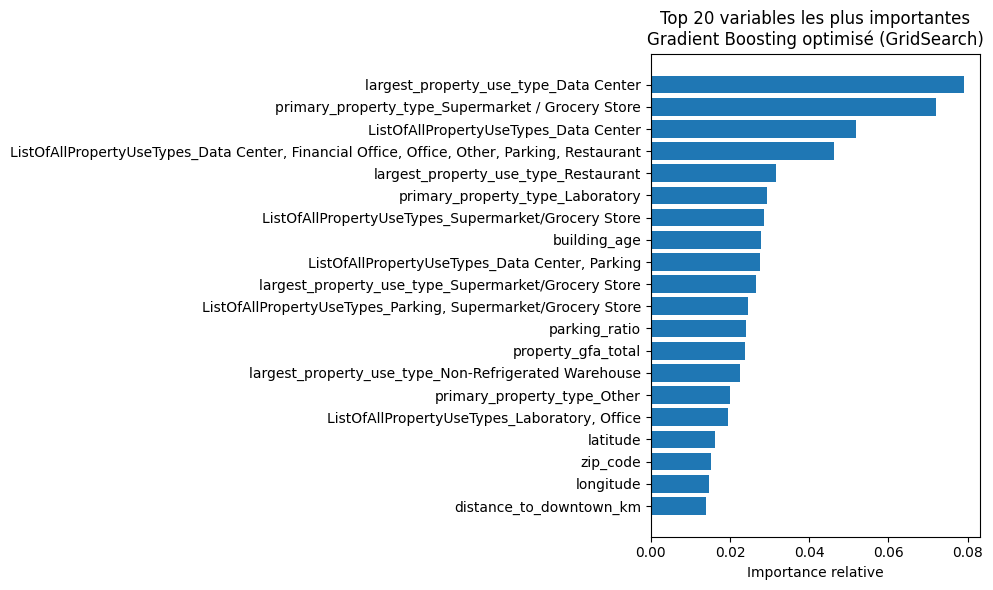

,feature,importance
0,largest_property_use_type_Data Center,0.079142
1,primary_property_type_Supermarket / Grocery Store,0.072094
2,ListOfAllPropertyUseTypes_Data Center,0.051850
3,"ListOfAllPropertyUseTypes_Data Center, Financi...",0.046379
4,largest_property_use_type_Restaurant,0.031723
5,primary_property_type_Laboratory,0.029364
6,ListOfAllPropertyUseTypes_Supermarket/Grocery ...,0.028530
7,building_age,0.027841
8,"ListOfAllPropertyUseTypes_Data Center, Parking",0.027586
9,largest_property_use_type_Supermarket/Grocery ...,0.026491


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

# =====================================================
# 1) Récupération du meilleur pipeline issu du GridSearch
# =====================================================
best_model = grid_search_gb.best_estimator_

# =====================================================
# 2) Identification automatique du préprocesseur
#    et du modèle Gradient Boosting dans le pipeline
# =====================================================
preprocessor = None
regressor = None

for step_name, step in best_model.named_steps.items():
    if isinstance(step, ColumnTransformer):
        preprocessor = step
        print(f"Préprocesseur trouvé dans l'étape : '{step_name}'")
    if isinstance(step, GradientBoostingRegressor):
        regressor = step
        print(f"Modèle Gradient Boosting trouvé dans l'étape : '{step_name}'")

if preprocessor is None or regressor is None:
    raise RuntimeError(
        "Impossible de retrouver le préprocesseur ou le modèle Gradient Boosting dans le pipeline."
    )

# =====================================================
# 3) Récupération des noms des variables utilisées
# =====================================================

# Variables numériques (avant transformation)
num_features = np.array(numeric_features)

# Variables catégorielles après OneHotEncoding
cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

# Liste finale des features vues par le modèle
feature_names = np.concatenate([num_features, cat_features])

# =====================================================
# 4) Importances des variables (Gradient Boosting)
# =====================================================
importances = regressor.feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# =====================================================
# 5) Visualisation des 20 variables les plus importantes
# =====================================================
top_n = 20
feat_top = feat_imp.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(feat_top["feature"], feat_top["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance relative")
plt.title(
    f"Top {top_n} variables les plus importantes\n"
    "Gradient Boosting optimisé (GridSearch)"
)
plt.tight_layout()
plt.show()

# Affichage tabulaire (utile pour le rapport)
feat_top


### 5.6 Interprétation du modèle : importance des variables

L’analyse des importances issues du **Gradient Boosting optimisé** met en évidence que la prédiction de la consommation énergétique repose principalement sur les **usages du bâtiment**, complétés par ses **caractéristiques physiques** et, dans une moindre mesure, par sa **localisation**.

Les variables les plus influentes sont :

- **le type d’usage du bâtiment**, qui constitue le facteur dominant de la prédiction.  
  Les usages fortement énergivores tels que les **data centers**, les **supermarchés** ou les **restaurants** apparaissent comme particulièrement déterminants, que ce soit via l’usage principal (`primary_property_type`, `largest_property_use_type`) ou via la combinaison des usages (`ListOfAllPropertyUseTypes`).

- **les caractéristiques physiques du bâtiment**, notamment :
  - la **surface totale** (`property_gfa_total`),
  - l’**ancienneté du bâtiment** (`building_age`),
  - le **ratio de surface de parking** (`parking_ratio`),  
  qui influencent directement les besoins en chauffage, climatisation et éclairage.

- **la complexité fonctionnelle du bâtiment**, mise en évidence par les variables liées aux **bâtiments multi-usages**, traduisant des profils de consommation plus hétérogènes et difficiles à optimiser.

- **la localisation géographique**, via les coordonnées (`latitude`, `longitude`), le code postal (`zip_code`) et la **distance au centre-ville** (`distance_to_downtown_km`), qui joue un rôle secondaire mais non négligeable, en lien avec le contexte urbain et la typologie des bâtiments.

Ces résultats montrent que la **fonction du bâtiment** est le principal déterminant de la consommation énergétique, devant sa taille et son ancienneté, tandis que la localisation agit comme un facteur contextuel.  
L’ensemble des variables créées lors du feature engineering est effectivement exploité par le modèle, confirmant leur **pertinence** et la **cohérence métier** des choix réalisés.


In [63]:
import numpy as np

# Test de robustesse aux valeurs manquantes
X_test_nan = X_test.iloc[[0]].copy()

X_test_nan.iloc[0, 0] = np.nan
if X_test_nan.shape[1] > 1:
    X_test_nan.iloc[0, 1] = None

_ = best_gb_model.predict(X_test_nan)

print("Test anti-NaN : OK")


Test anti-NaN : OK


In [64]:
print("Features utilisées par le pipeline :")
print(X_train.columns.tolist())


Features utilisées par le pipeline :
['building_type', 'primary_property_type', 'zip_code', 'council_district_code', 'neighborhood', 'latitude', 'longitude', 'number_of_buildings', 'number_of_floors', 'property_gfa_total', 'property_gfa_parking', 'ListOfAllPropertyUseTypes', 'largest_property_use_type', 'second_largest_property_use_type', 'second_largest_property_use_type_gfa', 'third_largest_property_use_type', 'third_largest_property_use_type_gfa', 'building_age', 'usage_count', 'parking_ratio', 'floor_density', 'distance_to_downtown_km']


## 6 – Modèle final déployable (filtrage des variables pour l’API)

Les sections précédentes ont permis d’explorer l’ensemble des variables disponibles et d’identifier les modèles les plus performants sur le plan prédictif.  
Cependant, dans une logique de mise en production via une API, toutes les variables du jeu de données initial ne sont pas nécessairement disponibles ou collectables en temps réel.

Cette section vise donc à **aligner le modèle final avec les contraintes de déploiement**, en restreignant volontairement le jeu de variables aux informations réellement exposées par l’API.








### 6.1 – Sélection des variables compatibles avec l’API

Un sous-ensemble de variables a été retenu selon deux critères :
- disponibilité réaliste via une API utilisateur,
- cohérence métier pour l’estimation de la consommation énergétique.

Les variables suivantes ont été conservées pour le modèle déployé :

- typologie et usage du bâtiment (`building_type`, `primary_property_type`)
- informations géographiques (`zip_code`, `neighborhood`, latitude, longitude)
- caractéristiques structurelles (surfaces, nombre d’étages et de bâtiments)
- informations synthétiques sur l’usage (`ListOfAllPropertyUseTypes`, `largest_property_use_type`)
- variables construites issues du feature engineering (âge du bâtiment, ratios, distance au centre-ville)

In [65]:
api_features = [
    "building_type",
    "primary_property_type",
    "zip_code",
    "neighborhood",
    "latitude",
    "longitude",
    "number_of_buildings",
    "number_of_floors",
    "property_gfa_total",
    "property_gfa_parking",
    "ListOfAllPropertyUseTypes",
    "largest_property_use_type",
    "building_age",
    "usage_count",
    "parking_ratio",
    "floor_density",
    "distance_to_downtown_km",
]

X_api = X[api_features].copy()



### 6.2 – Sélection des variables compatibles avec l’API

In [67]:
# ============================================================
# 6.2 — Préprocesseur dédié à X_api (cohérent avec le filtrage)
# 6.3 — Split + entraînement du pipeline final
# Pré-requis :
#   - X_api existe déjà (ex: X_api = X[api_features].copy())
#   - y existe déjà
#   - numpy est importé si besoin ailleurs
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor

# -------------------------
# 6.2 — Construction d'un preprocessor strictement basé sur X_api
# -------------------------
numeric_features_api = X_api.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_api = X_api.select_dtypes(include=["object", "string"]).columns.tolist()

numeric_transformer_api = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_api = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_api = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_api, numeric_features_api),
        ("cat", categorical_transformer_api, categorical_features_api),
    ],
    remainder="drop",
)

print("Preprocessor API prêt.")
print("Numériques API :", numeric_features_api)
print("Catégorielles API :", categorical_features_api)

# -------------------------
# 6.3 — Split + entraînement du pipeline final
# -------------------------
X_train_api, X_test_api, y_train_api, y_test_api = train_test_split(
    X_api, y, test_size=0.2, random_state=42
)

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_api),
    ("model", GradientBoostingRegressor(
        random_state=42,
        # hyperparamètres optimisés à reporter ici (issus du GridSearch)
        # ex:
        # n_estimators=200,
        # learning_rate=0.1,
        # max_depth=4,
    )),
])

final_pipeline.fit(X_train_api, y_train_api)

print("Pipeline final entraîné.")


Preprocessor API prêt.
Numériques API : ['zip_code', 'latitude', 'longitude', 'number_of_buildings', 'number_of_floors', 'property_gfa_total', 'property_gfa_parking', 'building_age', 'usage_count', 'parking_ratio', 'floor_density', 'distance_to_downtown_km']
Catégorielles API : ['building_type', 'primary_property_type', 'neighborhood', 'ListOfAllPropertyUseTypes', 'largest_property_use_type']
Pipeline final entraîné.


6.4 Test anti-NaN

In [68]:
import numpy as np

X_test_nan = X_test_api.iloc[[0]].copy()
X_test_nan.iloc[0, 0] = np.nan
if X_test_nan.shape[1] > 1:
    X_test_nan.iloc[0, 1] = None

_ = final_pipeline.predict(X_test_nan)
print("Test anti-NaN (pipeline final) : OK")


Test anti-NaN (pipeline final) : OK


### 6.6 Export Bentoml

In [1]:
import bentoml

# Export du pipeline final aligné API (préprocessing + GradientBoosting)
tag = bentoml.sklearn.save_model(
    name="seattle_energy_gb",
    model=final_pipeline,
    custom_objects={
        "feature_names": X_api.columns.tolist()
    }
)

print("Modèle final (API-compatible) sauvegardé :", tag)


NameError: name 'final_pipeline' is not defined